# Loading Raw Ephys Data (AP and LFP band)

In [1]:
# Turn off logging and disable tqdm this is a hidden cell on docs page
import logging
import os

logger = logging.getLogger('ibllib')
logger.setLevel(logging.CRITICAL)

os.environ["TQDM_DISABLE"] = "1"

Raw electrophysiology data recorded using spikeglx and compressed using [mtscomp](https://github.com/int-brain-lab/mtscomp)
The recommended way to load raw AP or LF band data for analysis is by using the `SpikeSortingLoader`.

This will gather all the relevant meta-data for a given probe and the histology reconstructed channel locations in the brain. 

## AP and LF band streaming examples

### Get the raw data streamers and the meta-data
We start by instantiating a spike sorting loader object and reading in the histology information by loading the channels table.

In [2]:
%%capture
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader

one = ONE(base_url='https://openalyx.internationalbrainlab.org')
t0 = 100 # timepoint in recording to stream

pid = 'da8dfec1-d265-44e8-84ce-6ae9c109b8bd'
ssl = SpikeSortingLoader(pid=pid, one=one)
# The channels information is contained in a dict table / dataframe
channels = ssl.load_channels()

# Get AP and LFP spikeglx.Reader objects
sr_lf = ssl.raw_electrophysiology(band="lf", stream=True)
sr_ap = ssl.raw_electrophysiology(band="ap", stream=True)


Here we stream one second of raw AP data around the timepoint of interest and 5 seconds of data for the raw LF data

## Synchronisation
Each probe has its own internal clock and report to the main clock of the experiment. When loading the raw data, there is a sample to experiment clock operation necessary to align the raw data.

### Streaming data around a task event

In [3]:
%%capture
stimOn_times = one.load_object(ssl.eid, 'trials', collection='alf')['stimOn_times']
event_no = 100
# timepoint in recording to stream, as per the experiment main clock 
t_event = stimOn_times[event_no]

# corresponding sample in the AP data
s_event = int(ssl.samples2times(stimOn_times[event_no], direction='reverse'))
print(f'raw AP band sample for event at time {t_event}: {s_event}')

# get the AP data surrounding samples
window_secs_ap = [-0.05, 0.05]  # we'll look at 50ms before and after the event for AP
first, last = (int(window_secs_ap[0] * sr_ap.fs) + s_event, int(window_secs_ap[1] * sr_ap.fs + s_event))
raw_ap = sr_ap[first:last, :-sr_ap.nsync].T

# get the LF data surrounding samples
window_secs_ap = [-0.750, 0.750]  # we'll look at 750ms before and after the event because LF varies more slowly in time
sample_lf = s_event // 12  # NB: for neuropixel probes this is always 12 because AP is sampled at 12x the frequency of LF
first, last = (int(window_secs_ap[0] * sr_lf.fs) + sample_lf, int(window_secs_ap[1] * sr_lf.fs + sample_lf))
raw_lf = sr_lf[first:last, :-sr_lf.nsync].T

<div class="alert alert-info">
Note:
    
**Why the transpose and the slicing in `sr_lf[first:last, :-sr_lf.nsync].T` ?**

- we transpose (`.T`) our internal representation of the `raw` data. On disk by experimental necessity, the data is sorted by time sample first, channel second; this is not desirable for pre-processing as time samples are not contiguous.This is why our internal representation for the raw data snippets (i.e. dimensions used when working with such data) is `[number of channels, number of samples]`, in Python c-ordering, the time samples are contiguous in memory.

- the raw data will contain the synching channels (i.e. the voltage information contained on the analog and digital DAQ channels, that mark events in the task notably). You need to remove them before wanting to use solely the raw ephys data (e.g. for plotting or exploring).

</div>

### Display the data with channel information around a task event

(<Figure size 1800x1200 with 4 Axes>, <Axes: >)

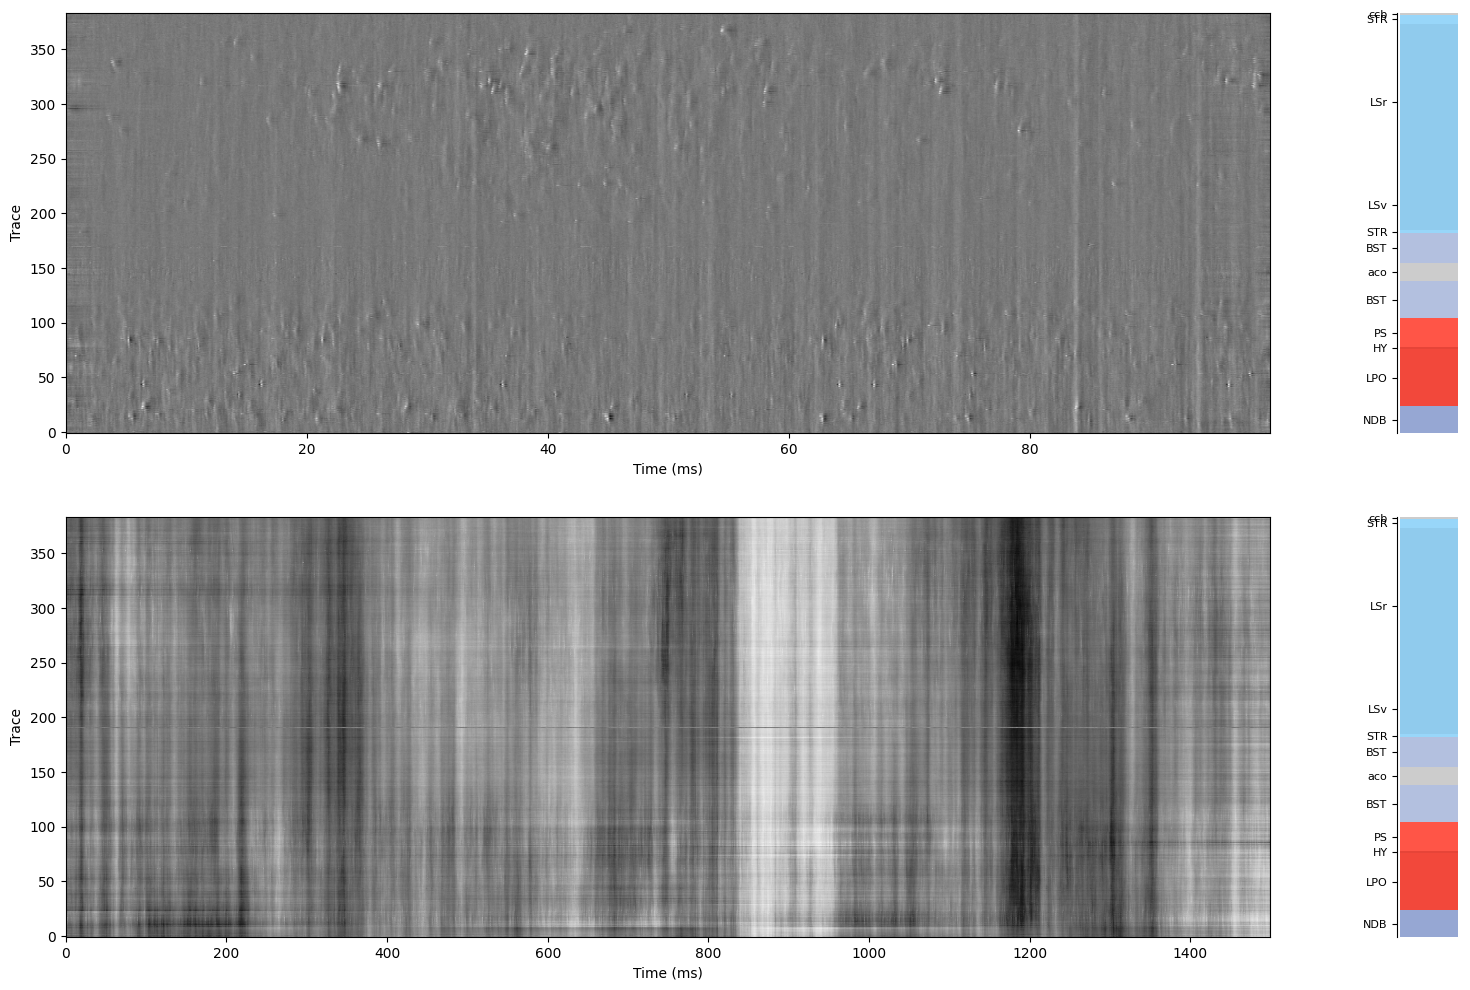

In [4]:
import matplotlib.pyplot as plt
import scipy.signal
from brainbox.ephys_plots import plot_brain_regions
from ibllib.plots import Density
sos_ap = scipy.signal.butter(3, 300 / sr_ap.fs /2, btype='highpass', output='sos')  # 300 Hz high pass AP band
sos_lf = scipy.signal.butter(3,   2 / sr_lf.fs /2, btype='highpass', output='sos')  #   2 Hz high pass LF band
filtered_ap = scipy.signal.sosfiltfilt(sos_ap, raw_ap)
filtered_lf = scipy.signal.sosfiltfilt(sos_lf, raw_lf)

# displays the AP band and LFP band around this stim_on event
fig, axs = plt.subplots(2, 2, gridspec_kw={'width_ratios': [.95, .05]}, figsize=(18, 12))
Density(- filtered_ap, fs=sr_ap.fs, taxis=1, ax=axs[0, 0])
plot_brain_regions(channels["atlas_id"], channel_depths=channels["axial_um"], ax = axs[0, 1], display=True)
Density(- filtered_lf, fs=sr_lf.fs, taxis=1, ax=axs[1, 0])
plot_brain_regions(channels["atlas_id"], channel_depths=channels["axial_um"], ax = axs[1, 1], display=True)

<div class="alert alert-info">
Note:

If you plan on computing time aligned averages on many events, it will be much more efficient to download the raw data files once and for all instead of using the streaming cache. This way you have full control over the disk space usage and the bulky data retention policy.

The following example shows hot to instantiate the same objects as above with a full downloaded file instead of streaming.
</div>

### Downloading the raw data

<div class="alert alert-warning">
Warning.

The raw ephys data is very large and downloading will take a long period of time and fill up your hard drive pretty fast.

</div>

When accessing the raw electrophysiology method of the spike sorting loader, turning the streaming mode off will download the full
file if it is not already present in the cache.

We recommend setting the path of your `ONE` instance to make sure you control the destination path of the downloaded data.

```python
PATH_CACHE = Path("/path_to_raw_data_drive/openalyx")
one = ONE(base_url="https://openalyx.internationalbrainlab.org", cache_dir=PATH_CACHE)
sr_ap = ssl.raw_electrophysiology(band='ap', stream=False)  # sr_ap is a spikeglx.Reader object that uses memmap
```


## Exploring raw ephys data

### Example 1: Destripe AP data
This is very important to do prior to using the raw data, as it removes artifacts (see our [Spikesorting white paper](https://figshare.com/articles/online_resource/Spike_sorting_pipeline_for_the_International_Brain_Laboratory/19705522) for details).

In [5]:
from ibldsp.voltage import destripe
# Reminder : If not done before, remove first the sync channel from raw data
# Apply destriping algorithm to data
destriped = destripe(raw_ap, fs=sr_ap.fs)

To view and explore the raw ephys data, we recommend you use the [viewephys tool](https://github.com/oliche/viewephys).

In [ ]:
%gui qt
from viewephys.gui import viewephys
v_raw = viewephys(raw_ap, fs=sr.fs)
v_des = viewephys(destriped, fs=sr.fs)
# You will then be able to zoom in, adjust the gain etc - see README for details

For the sake of presenting the data pre and post destriping as part of this tutorial, we are using an alternative plotting method (`matplotlib`).

Text(0, 0.5, '')

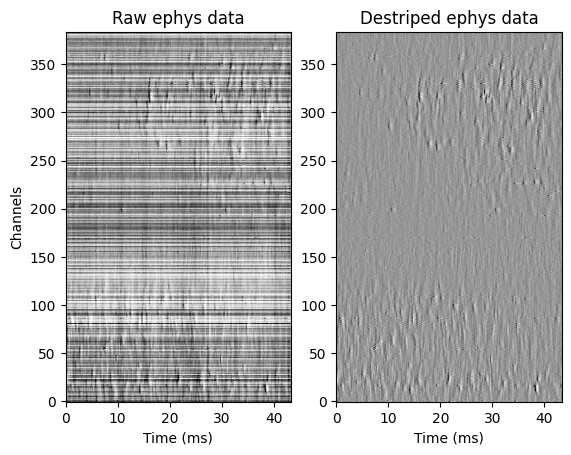

In [6]:
from ibllib.plots import Density
import matplotlib.pyplot as plt

DISPLAY_TIME = 0.05  # second
SAMPLE_SKIP = 200  # Skip beginning for show, otherwise blurry due to filtering edge effect
MIN_X = -0.00011
MAX_X = -MIN_X

# Shorten and transpose the data for plotting
X = destriped[:, :int(DISPLAY_TIME * sr_ap.fs)].T
Xs = X[SAMPLE_SKIP:].T  # Remove apodization at begining
Tplot = Xs.shape[1] / sr_ap.fs

X_raw = raw_ap[:, :int(DISPLAY_TIME * sr_ap.fs)].T
Xs_raw = X_raw[SAMPLE_SKIP:].T  # Remove apodization at begining

# Plot
fig, axs = plt.subplots(nrows=1, ncols=2)

i_plt = 0
d0 = Density(-Xs_raw, fs=sr_ap.fs, taxis=1, ax=axs[i_plt],  vmin=MIN_X, vmax=MAX_X, cmap='Greys')
axs[i_plt].title.set_text('Raw ephys data')
axs[i_plt].set_xlim((0, Tplot * 1e3))
axs[i_plt].set_ylabel('Channels')

i_plt = 1
d1 = Density(-Xs, fs=sr_ap.fs, taxis=1, ax=axs[i_plt],  vmin=MIN_X, vmax=MAX_X, cmap='Greys')
axs[i_plt].title.set_text('Destriped ephys data')
axs[i_plt].set_xlim((0, Tplot * 1e3))
axs[i_plt].set_ylabel('')

## Low level loading and downloading functions

### Relevant datasets
The raw data comprises 3 files:
* `\_spikeglx_ephysData*.cbin` the compressed raw binary
* `\_spikeglx_ephysData*.meta` the metadata file from spikeglx
* `\_spikeglx_ephysData*.ch` the compression header containing chunks address in the file

The raw data is compressed with a lossless compression algorithm in chunks of 1 second each. This allows to retrieve parts of the data without having to uncompress the whole file. We recommend using the `spikeglx.Reader` module from [ibl-neuropixel repository](https://github.com/int-brain-lab/ibl-neuropixel)

Full information about the compression and tool in [mtscomp repository](https://github.com/int-brain-lab/mtscomp)

### Option 1: Stream snippets of raw ephys data
This is a useful option if you are interested to perform analysis on a chunk of data of smaller duration than the whole recording, as it will take less time to download. Data snippets can be loaded in chunks of 1-second, i.e. you can load at minimum 1 second of raw data, and any multiplier of such chunk length (for example 4 or 92 seconds).

In [7]:
%%capture
from one.api import ONE
from brainbox.io.spikeglx import Streamer

one = ONE()

pid = 'da8dfec1-d265-44e8-84ce-6ae9c109b8bd'

t0 = 100 # timepoint in recording to stream
band = 'ap' # either 'ap' or 'lf'

sr = Streamer(pid=pid, one=one, remove_cached=False, typ=band)
first, last = (int(t0 * sr.fs), int((t0 + 1) * sr.fs))

# Important: remove sync channel from raw data, and transpose to get a [n_channels, n_samples] array
raw = sr[first:last, :-sr.nsync].T

### Option 2: Download all of raw ephys data

<div class="alert alert-warning">
Warning.

The raw ephys data is very large and downloading will take a long period of time.


</div>

In [ ]:
from one.api import ONE
import spikeglx
one = ONE()

pid = 'da8dfec1-d265-44e8-84ce-6ae9c109b8bd'
eid, probe = one.pid2eid(pid)

band = 'ap' # either 'ap','lf'

# Find the relevant datasets and download them
dsets = one.list_datasets(eid, collection=f'raw_ephys_data/{probe}', filename='*.lf.*')
data_files, _ = one.load_datasets(eid, dsets, download_only=True)
bin_file = next(df for df in data_files if df.suffix == '.cbin')

# Use spikeglx reader to read in the whole raw data
sr = spikeglx.Reader(bin_file)
print(sr.shape)

## More details
* [Details of raw ap datasets](https://docs.google.com/document/d/1OqIqqakPakHXRAwceYLwFY9gOrm8_P62XIfCTnHwstg/edit#heading=h.ms0y69xbzova)
* [Details of raw lfp datasets](https://docs.google.com/document/d/1OqIqqakPakHXRAwceYLwFY9gOrm8_P62XIfCTnHwstg/edit#heading=h.nct1c3j9tedk)
* [Details of mtscomp compression algorithm](https://github.com/int-brain-lab/mtscomp#readme)
* [Spikesorting white paper](https://figshare.com/articles/online_resource/Spike_sorting_pipeline_for_the_International_Brain_Laboratory/19705522)

## Useful modules
* [ibllib.io.spikeglx](https://int-brain-lab.github.io/ibl-neuropixel/_autosummary/spikeglx.html)
* [ibllib.voltage.dsp](https://int-brain-lab.github.io/ibl-neuropixel/_autosummary/ibldsp.voltage.html)
* [brainbox.io.spikeglx.stream](https://int-brain-lab.github.io/iblenv/_autosummary/brainbox.io.spikeglx.html#brainbox.io.spikeglx.stream)
* [viewephys](https://github.com/oliche/viewephys) to visualise raw data snippets (Note: this package is not within `ibllib` but standalone)

## Other relevant examples
* If you wish for further examples, do not hesitate to [contact us](https://int-brain-lab.github.io/iblenv/public_docs/information_contact.html).